# **Welcome to SAC's Basketball Bash Hype or Boom Workshop! 🏀**

## In this workshop we will cover the following:
1) Fetching and cleaning NBA player game log data
2) Analyzing weekly player performance in the last two seasons
3) Projecting every player's weekly box score performance for this season
4) Applying the projections to Fantasy Baskebtall CATs!

## **1. Installing and Importing Libraries**

In [1]:
# MUST INSTALL! We will be using the nba_api to fetch our data
!pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.0/287.0 kB 6.1 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time # Added for sleep delay
from datetime import datetime, timedelta

from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import playergamelog

'''
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
'''

'\nfrom sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.multioutput import MultiOutputRegressor\nfrom sklearn.preprocessing import StandardScaler, OneHotEncoder\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\n'

## **2. Creating Dataset with NBA API!**

In [3]:
def get_all_players():
# Return all active and historical players from NBA API
  plist = players.get_players()
  df_players = pd.DataFrame(plist)
  return df_players

In [4]:
# View the df_players data which consists of players' id, name, and if they are active/inactive
df_players = get_all_players()
df_players

,id,full_name,first_name,last_name,is_active
0,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False
1,76002,Zaid Abdul-Aziz,Zaid,Abdul-Aziz,False
2,76003,Kareem Abdul-Jabbar,Kareem,Abdul-Jabbar,False
3,51,Mahmoud Abdul-Rauf,Mahmoud,Abdul-Rauf,False
4,1505,Tariq Abdul-Wahad,Tariq,Abdul-Wahad,False
...,...,...,...,...,...
5130,78650,Matt Zunic,Matt,Zunic,False
5131,1641783,Tristan da Silva,Tristan,da Silva,True
5132,1628427,Vlatko Čančar,Vlatko,Čančar,True
5133,1642365,Nikola Đurišić,Nikola,Đurišić,False


In [5]:
def get_player_gamelogs(player_id, start_season=2023, end_season=2024):
  """
  Pulls player game logs for each season in the specified range with retry logic.
  Increased robustness against API timeouts.
  """

  # Initialize an empty data frame which will be used for concatening data
  frames = []

  # MAX_RETRIES represents the number of tries to fetch data if timeouts are thrown
  MAX_RETRIES = 3

  # Pulls the player game log for a specified player from the range of seasons
  for season in tqdm(range(start_season, end_season+1), desc=f"Player {player_id}"):
    # Creates a specialized season string in the following format (i.e. 2023-24)
    season_str = f"{season}-{str(season+1)[-2:]}"
    # Fetch the data from the NBA API
    for attempt in range(MAX_RETRIES):
      try:
        # 1. Fetch the game log. The NBA API client handles its own default timeouts.
        gl = playergamelog.PlayerGameLog(player_id=player_id, season=season_str).get_data_frames()[0]
        gl['SEASON'] = season_str
        frames.append(gl)

        # Add a short delay to respect API rate limits
        time.sleep(0.5)
        break # Success, break out of the retry loop

      except Exception as e:
        if attempt < MAX_RETRIES - 1:
          # Retry failed request after a longer wait
          print(f"Error fetching {player_id} {season_str} (Attempt {attempt + 1}/{MAX_RETRIES}): {e}. Retrying in 5 seconds...")
          time.sleep(5)
        else:
          print(f"Failed to fetch {player_id} {season_str} after {MAX_RETRIES} attempts.")
          # Suppress verbose error printing for missing seasons/data
          pass

  if frames:
    # Concatenate frames using the columns from the first valid frame
    # This addresses the FutureWarning and ensures columns align
    valid_frames = [f for f in frames if not f.empty]
    if valid_frames:
        df = pd.concat(valid_frames, ignore_index=True)
        df['PLAYER_ID'] = player_id
        return df

  # Return an empty DataFrame if the data fetching fails
  return pd.DataFrame()

In [6]:
def build_historical_dataset(player_limit=10, start_season=2023, end_season=2024, save_path='data/nba_player_gamelogs_api.csv',
                             batch_size = 10):
  """Fetches multiple players' logs and combines them."""
  df_players = get_all_players()
  # Sample players to keep the initial run manageable
  # Filter for players active during the timeframe
  active_players = df_players[df_players['is_active'] == True]

  # Condition for the number of players who should have their game logs pulled
  if player_limit and player_limit > 0:
      selected = active_players.sample(min(player_limit, len(active_players)), random_state=42)
  else:
      selected = active_players

  all_logs = []
  os.makedirs(os.path.dirname(save_path), exist_ok=True)
  print(f"Fetching game logs for {len(selected)} players in batches of {batch_size}...")

  # Split players into batches
  player_ids = selected['id'].tolist()
  player_names = selected['full_name'].tolist()

  # Process in batches
  for i in range(0, len(player_ids), batch_size):
      batch_ids = player_ids[i:i+batch_size]
      batch_names = player_names[i:i+batch_size]

      for pid, pname in tqdm(zip(batch_ids, batch_names), total=len(batch_ids), desc=f"Batch {i//batch_size + 1}"):
          # Retry logic already exists in get_player_gamelogs
          df_logs = get_player_gamelogs(pid, start_season, end_season)
          if not df_logs.empty:
              df_logs['PLAYER_NAME'] = pname
              all_logs.append(df_logs)

  # Combine all fetched logs at the end
  if all_logs:
      df_all = pd.concat(all_logs, ignore_index=True)
      df_all.to_csv(save_path, index=False)
      print(f"\nSaved combined dataset: {save_path} with {len(df_all)} rows")
      return df_all
  else:
      print("No logs were fetched.")
      return pd.DataFrame()

## **3. Data Cleaning and Preparation**

In [7]:
def clean_nba_api_data(df):
  """
  Cleans and prepares the raw NBA game log data.
  (Rewritten and fixed to correctly convert 'min' column)
  """
  # Standardize column names
  df = df.rename(columns={c: c.lower() for c in df.columns})

  # FIX: Handle potential duplicate columns (e.g., 'player_id') resulting from lowercasing
  # This keeps the first occurrence of a column name and drops any subsequent duplicates.
  df = df.loc[:, ~df.columns.duplicated()]

  # Convert dates
  if 'game_date' in df.columns:
    df['game_date'] = pd.to_datetime(df['game_date'])

  # Select useful columns
  useful_cols = ['season', 'player_name', 'player_id','season_id', 'game_date', 'matchup', 'pts', 'reb', 'ast', 'stl', 'blk',
                 'fg3m', 'fga', 'fgm', 'fta', 'ftm', 'tov', 'min']
  df = df[[c for c in useful_cols if c in df.columns]].copy()

  # Function to convert minutes from 'MM:SS' format to float (e.g., 32.75)
  def convert_min(m):
    try:
      if isinstance(m, str) and ':' in m:
        mins, secs = m.split(':')
        return int(mins) + int(secs)/60
      return float(m)
    except:
      return np.nan

  # Apply minutes conversion and drop original 'min' column
  df['minutes'] = df['min'].apply(convert_min)
  df = df.drop(columns=['min'], errors='ignore')

  # Extract home/away, opponent from matchup string
  df['home_away'] = df['matchup'].apply(lambda x: 'A' if '@' in str(x) else 'H')
  df['opponent'] = df['matchup'].apply(lambda x: str(x).split()[-1])
  #df = df.drop(columns=['matchup'], errors='ignore')

  # Drop rows with missing values in key stat columns
  df = df.dropna(subset=['pts', 'reb', 'ast', 'stl', 'blk', 'fg3m', 'minutes',
                         'fga', 'fgm', 'fta', 'ftm', 'tov'])

  print(f"Cleaned dataset shape: {df.shape}")
  return df

In [8]:
# Now, let's test our workflow!
#  We'll make a separate df just to make sure our functions work, and then we'll move on!

df_raw = build_historical_dataset(player_limit=10, start_season=2023, end_season=2024)
df_clean = clean_nba_api_data(df_raw)
df_clean.to_csv('data/nba_cleaned_dataset.csv', index=False)

Fetching game logs for 10 players in batches of 10...


Batch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Player 1642281:   0%|          | 0/2 [00:00<?, ?it/s]

Player 1631288:   0%|          | 0/2 [00:00<?, ?it/s]

Player 1628408:   0%|          | 0/2 [00:00<?, ?it/s]

Player 1627832:   0%|          | 0/2 [00:00<?, ?it/s]

Player 1641727:   0%|          | 0/2 [00:00<?, ?it/s]

Player 1629726:   0%|          | 0/2 [00:00<?, ?it/s]

Player 1631243:   0%|          | 0/2 [00:00<?, ?it/s]

Player 1629628:   0%|          | 0/2 [00:00<?, ?it/s]

Player 1642264:   0%|          | 0/2 [00:00<?, ?it/s]

Player 1630231:   0%|          | 0/2 [00:00<?, ?it/s]


Saved combined dataset: data/nba_player_gamelogs_api.csv with 726 rows
Cleaned dataset shape: (726, 20)


In [9]:
# We would like to apply our workflow to a larger dataset which consists of
#   all of the players from the 2024 and 2025 seasons!

# Unfortunately, google colab does not support fetching large amounts of
#   game data, so you can find the dataset here:
#   https://github.com/Sarvesh30/SAC-Basketball-Bash-Workshop

# Let's read in the data from github:
df_gamelog_raw = pd.read_csv('https://raw.githubusercontent.com/Sarvesh30/SAC-Basketball-Bash-Workshop/refs/heads/main/nba_player_gamelogs_api.csv')
df_gamelog_clean = clean_nba_api_data(df_gamelog_raw)
df_gamelog_clean.to_csv('data/nba_player_gamelogs_cleaned_api.csv', index=False)

Cleaned dataset shape: (50176, 20)


In [10]:
# Let's take a look at the cleaned gamelog data
df_gamelog_clean

,season,player_name,player_id,season_id,game_date,matchup,pts,reb,ast,stl,blk,fg3m,fga,fgm,fta,ftm,tov,minutes,home_away,opponent
0,2023-24,Precious Achiuwa,1630173,22023,2024-04-14,NYK vs. CHI,4,5,2,0,1,0,3,2,0,0,2,19.0,H,CHI
1,2023-24,Precious Achiuwa,1630173,22023,2024-04-12,NYK vs. BKN,5,3,0,0,0,1,2,2,0,0,0,8.0,H,BKN
2,2023-24,Precious Achiuwa,1630173,22023,2024-04-11,NYK @ BOS,2,5,0,0,1,0,6,1,0,0,1,16.0,A,BOS
3,2023-24,Precious Achiuwa,1630173,22023,2024-04-07,NYK @ MIL,0,0,0,0,0,0,1,0,0,0,0,5.0,A,MIL
4,2023-24,Precious Achiuwa,1630173,22023,2024-04-05,NYK @ CHI,0,4,1,1,0,0,2,0,0,0,1,19.0,A,CHI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50171,2024-25,Dario Šarić,203967,22024,2024-11-01,DEN @ MIN,0,2,0,0,0,0,3,0,0,0,0,5.0,A,MIN
50172,2024-25,Dario Šarić,203967,22024,2024-10-29,DEN @ BKN,3,2,0,0,0,0,2,1,2,1,0,12.0,A,BKN
50173,2024-25,Dario Šarić,203967,22024,2024-10-28,DEN @ TOR,0,1,1,0,0,0,3,0,0,0,2,5.0,A,TOR
50174,2024-25,Dario Šarić,203967,22024,2024-10-26,DEN vs. LAC,0,2,0,0,0,0,2,0,0,0,0,11.0,H,LAC


## **4. Data Preprocessing and Projections**

In [11]:
# Sort the gamelog data by player_name and the game_date
df_gamelog_clean = df_gamelog_clean.sort_values(by=['player_name', 'game_date'])

# Create season-relative week numbers
def assign_season_week(df):
  df = df.copy()
  df['season_start'] = df.groupby('season')['game_date'].transform('min')
  df['season_week'] = (df['game_date'] - df['season_start']).dt.days // 7 + 1
  return df

df_gamelog_clean = assign_season_week(df_gamelog_clean)

# Sort by season_week for every player
df_gamelog_clean = df_gamelog_clean.sort_values(by=['player_name', 'season_week'], ascending = True)

In [12]:
# Aggregate per week stats for each player
df_player_weekly = df_gamelog_clean.groupby(['player_name', 'season_week', 'season']).agg({
    'pts': 'sum',
    'reb': 'sum',
    'ast': 'sum',
    'stl': 'sum',
    'blk': 'sum',
    'fg3m': 'sum',
    'fga':'sum',
    'fgm':'sum',
    'fta':'sum',
    'ftm':'sum',
    'tov':'sum',
    'minutes':'sum'
}).reset_index()

In [13]:
# Fill all null values with zero in df_player_weekly
df_player_weekly = df_player_weekly.fillna(0)

# Sort by the season and season_week
df_player_weekly = df_player_weekly.sort_values(by=['season', 'season_week'])

In [14]:
df_player_weekly[df_player_weekly['player_name'] == 'Giannis Antetokounmpo']

,player_name,season_week,season,pts,reb,ast,stl,blk,fg3m,fga,fgm,fta,ftm,tov,minutes
6047,Giannis Antetokounmpo,1,2023-24,82,30,8,3,5,1,56,31,30,19,12,96.0
6049,Giannis Antetokounmpo,2,2023-24,74,24,11,2,3,4,48,26,28,18,13,99.0
6051,Giannis Antetokounmpo,3,2023-24,139,42,17,4,5,1,85,53,50,32,18,130.0
6053,Giannis Antetokounmpo,4,2023-24,98,36,24,4,2,1,59,44,18,9,12,100.0
6055,Giannis Antetokounmpo,5,2023-24,85,38,14,6,4,0,60,29,40,27,10,113.0
6057,Giannis Antetokounmpo,6,2023-24,91,35,20,7,7,1,53,36,22,18,14,115.0
6059,Giannis Antetokounmpo,7,2023-24,104,30,18,5,2,1,54,37,40,29,7,116.0
6061,Giannis Antetokounmpo,8,2023-24,112,39,12,5,1,1,59,37,56,37,10,102.0
6063,Giannis Antetokounmpo,9,2023-24,108,44,35,4,6,1,78,39,42,29,15,142.0
6065,Giannis Antetokounmpo,10,2023-24,96,44,24,2,4,0,54,35,35,26,9,104.0


In [15]:
# Forecast the weekly box score stats for every player in the 2025-2026 season
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

# Set the target categories
categories = ['pts','reb','ast','stl','blk','fg3m','fga','fgm',
              'fta', 'ftm', 'tov']

# Create new per-minute columns
for stat in categories:
    df_player_weekly[f'{stat}_per_min'] = df_player_weekly[stat] / df_player_weekly['minutes']

forecast_list = []

# Traverse through every player in df_player_weekly
for player in df_player_weekly['player_name'].unique():
  # pulls the weekly data for every player
  player_df = df_player_weekly[df_player_weekly['player_name'] == player]

  # Traverse through every target category
  for stat in categories:
      ts = player_df.sort_values('season_week').set_index('season_week')[f'{stat}_per_min']

      # Skip if less than 5 weeks
      if len(ts) < 5:
        continue

      # Fit a simple exponential smoothing model
      model = ExponentialSmoothing(ts, trend = 'add', seasonal = None).fit(
          smoothing_level = 0.5, smoothing_slope = 0.1
      )

      # Forecast the weekly performance for the 2025-2026 season
      forecast_weeks = 25
      forecast = model.forecast(forecast_weeks)
      forecast = forecast.clip(lower=0)

      # If this is FGM, cap it to FGA forecast
      if stat == 'fgm':
          fga_ts = player_df.sort_values('season_week').set_index('season_week')['fga_per_min']
          if len(fga_ts) >= 5:
              fga_model = ExponentialSmoothing(fga_ts, trend='add', seasonal=None).fit(
                  smoothing_level=0.5, smoothing_slope=0.1
              )
              fga_forecast = fga_model.forecast(forecast_weeks).clip(lower=0)
              forecast = np.minimum(forecast, fga_forecast)  # cap FGM by FGA

      # Do the same for FTM, cap it to FTA forecast
      if stat == 'ftm':
        fta_ts = player_df.sort_values('season_week').set_index('season_week')['fta_per_min']
        if len(fta_ts) >= 5:
            fta_model = ExponentialSmoothing(fta_ts, trend='add', seasonal=None).fit(
                smoothing_level=0.5, smoothing_slope=0.1
            )
            fta_forecast = fta_model.forecast(forecast_weeks).clip(lower=0)
            forecast = np.minimum(forecast, fta_forecast)  # cap FTM by FTA


      # Append the forecasted weekly averages for every player to forecast_list
      temp = pd.DataFrame({
            'player_name': player,
            'season_week': range(1, forecast_weeks + 1),
            'category': stat,
            'forecast_value': forecast
        })
      forecast_list.append(temp)

forecast_df = pd.concat(forecast_list, ignore_index = True)

In [16]:
# Create a pivot table for the projections
forecast_wide = forecast_df.pivot_table(
    index=['player_name', 'season_week'],
    columns='category',
    values='forecast_value'
).reset_index()

In [17]:
# Average minutes per player
avg_minutes = df_player_weekly.groupby('player_name')['minutes'].mean().reset_index()
avg_minutes.rename(columns = {'minutes': 'expected_minutes'}, inplace = True)

# Merge expected minutes into forecast table
forecast_wide = forecast_wide.merge(avg_minutes, on = 'player_name', how = 'left')

# Multiply per-minute statistics by expected minutes
for stat in categories:
  forecast_wide[stat] = forecast_wide[stat] * forecast_wide['expected_minutes']

In [18]:
# Create ft% and fg% columns in forecast_wide
forecast_wide['ft%'] = forecast_wide['ftm'] / forecast_wide['fta']
forecast_wide['fg%'] = forecast_wide['fgm'] / forecast_wide['fga']

## **5. Data Visualizations and SAC's Fantasy Draft Board**

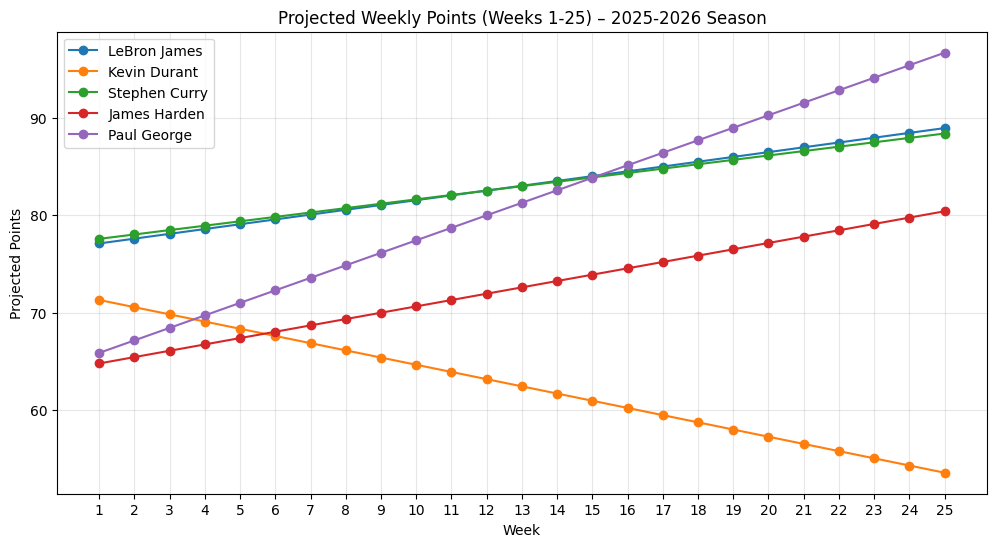

In [19]:
# Filter for the players we want
players = ['LeBron James', 'Kevin Durant', 'Stephen Curry', 'James Harden', 'Paul George']
plot_df = forecast_wide[forecast_wide['player_name'].isin(players)]

# Set up the plot
plt.figure(figsize=(12, 6))
for player in players:
    player_data = plot_df[plot_df['player_name'] == player]
    plt.plot(player_data['season_week'], player_data['pts'], marker='o', label=player)

plt.title('Projected Weekly Points (Weeks 1-25) – 2025-2026 Season')
plt.xlabel('Week')
plt.ylabel('Projected Points')
plt.xticks(range(1, 26))  # show all weeks
plt.grid(alpha=0.3)
plt.legend()
plt.show()

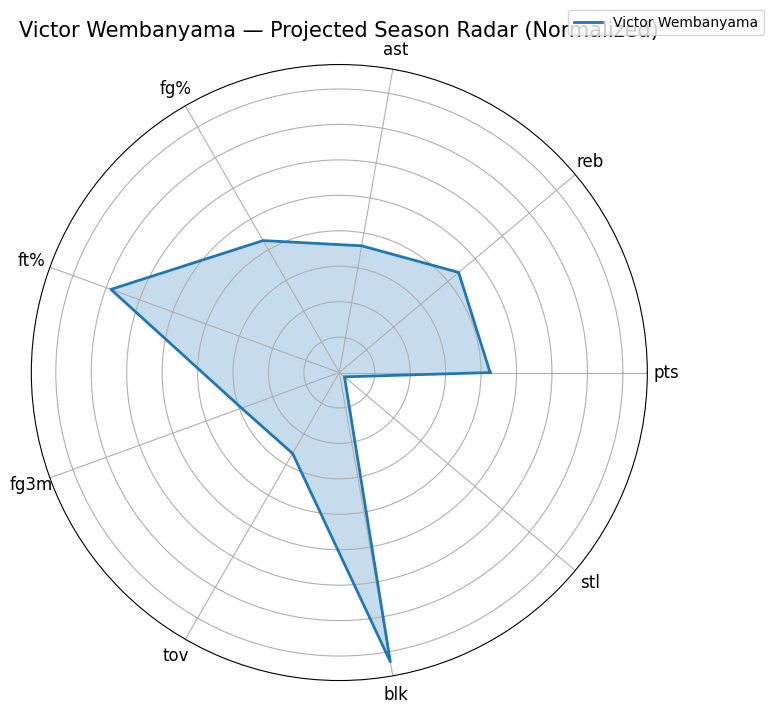

In [20]:
# Categories for radar
categories = ['pts', 'reb', 'ast', 'fg%', 'ft%', 'fg3m', 'tov', 'blk', 'stl']

# Select only those columns that exist
categories = [c for c in categories if c in forecast_wide.columns]

# Compute min-max across all players for each category
scaled_df = forecast_wide.copy()
for cat in categories:
    min_val = scaled_df[cat].min()
    max_val = scaled_df[cat].max()
    scaled_df[cat] = (scaled_df[cat] - min_val) / (max_val - min_val)

player = 'Victor Wembanyama'
player_data = scaled_df[scaled_df['player_name'] == player]

# Take mean across weeks
values = player_data[categories].mean().values

# Close the radar loop
values = values.tolist()
values += values[:1]  # loop back
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

# Plot
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
ax.plot(angles, values, linewidth=2, linestyle='solid', label=player)
ax.fill(angles, values, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_yticklabels([])  # hide radial ticks
ax.set_title(f'{player} — Projected Season Radar (Normalized)', size=15, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()

In [21]:
import plotly.express as px
import plotly.graph_objects as go

# Fantasy categories
fantasy_categories = ['pts','reb','ast','stl','blk','fg3m','fg%','ft%','tov']

# Example weights (users can adjust these before plotting)
weights = {
    'pts': 1.0, 'reb': 1.0, 'ast': 1.0, 'stl': 1.0, 'blk': 1.0,
    'fg3m': 1.0, 'fg%': 0.5, 'ft%': 0.5, 'tov': -1.0  # negative weight for turnovers
}

# Compute per-player average of standardized stats
player_avg_scaled = scaled_df.groupby('player_name')[fantasy_categories].mean().reset_index()

# Compute weighted draft score
player_avg_scaled['draft_score'] = sum(player_avg_scaled[cat] * w for cat, w in weights.items())

# Sort descending by draft score
player_avg_scaled = player_avg_scaled.sort_values('draft_score', ascending=False)

# Drop entries with NA for draft_score
player_avg_scaled = player_avg_scaled.dropna(subset=['draft_score'])

In [22]:
# Final Fantasy Draft Board
fig = go.Figure(data=[go.Table(
    header=dict(
        values=['Player'] + fantasy_categories + ['Draft Score'],
        fill_color='orange',
        align='left',
        font=dict(color='white', size=14)  # change header text color & size
    ),
    cells=dict(
        values=[player_avg_scaled[col] for col in ['player_name'] + fantasy_categories + ['draft_score']],
        fill_color='green',
        align='left',
        font=dict(color='white', size=12)  # change body text color & size
    )
)])

fig.show()